## Final project - Group 90 - Predicting cumulative oil production
Date: 12-11-2022

Loading packages

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import eli5
from eli5.sklearn import PermutationImportance

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

from sklearn.feature_selection import f_regression
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
import joblib
from joblib import dump, load
import matplotlib.pyplot as plt

import xgboost as xgb
import sys

from timeit import default_timer as timer
from sklearn import metrics as skmet
from sklearn import model_selection as mselect

**Helper functions for creating a dictionary of results**

In [1]:
#Creating df with first entry
def create_results_df(model, X_train, y_train, X_test, y_test):
    """Create a dataframe with the results of a model"""
    results_dict = {
        'model': [],
        'training score': [],
        'testing score': [],
    }
    
    results_dict['model'].append(model.__class__.__name__)
    results_dict['training score'].append(model.score(X_train, y_train))
    results_dict['testing score'].append(model.score(X_test, y_test))
    
    return pd.DataFrame(results_dict)

In [3]:
#Add single new entry
def add_to_results_df(results_df, model, X_train, y_train, X_test, y_test):
    """Add a model to a results dataframe"""
    results_dict = {
        'model': [],
        'training score': [],
        'testing score': [],
    }
    
    results_dict['model'].append(model.__class__.__name__)
    results_dict['training score'].append(model.score(X_train, y_train))
    results_dict['testing score'].append(model.score(X_test, y_test))
    
    return pd.concat([results_df, pd.DataFrame(results_dict)], axis=0)

In [4]:
#Add multiple entries
def add_multiple_to_results_df(results_df, models, X_train, y_train, X_test, y_test):
    """Add multiple models to a results dataframe"""
    for model in models:
        results_df = add_to_results_df(results_df, model, X_train, y_train, X_test, y_test)
    return results_df

### Processing and EDA

In [2]:
og_raw = pd.read_csv('og_data.csv', parse_dates=[2])
og_full = og_raw.assign(
    cmonth=og_raw.CompletionDate.dt.month,
    cweekday=og_raw.CompletionDate.dt.weekday,
)

og_full = og_full.loc[og_full.CompletionDate >= pd.Timestamp('2011-1-1')]

og_full = og_full.query('Reservoir not in  (4, )')

og_full = og_full.loc[~(og_full[[
    'HzDistanceToNearestOffsetAtDrill',
    'HzDistanceToNearestOffsetCurrent',
    'VtDistanceToNearestOffsetCurrent',
    'VtDistanceToNearestOffsetAtDrill'
]] < 1).any(axis=1)]

cols_wnull = og_full.columns[og_full.isnull().any()]
og_full = pd.concat(
    [
        og_full, 
        og_full[cols_wnull].isnull().astype(int).rename(
            columns=lambda x: x + '_Null'
        )
    ],
    axis=1
)

og_dist_capped = (og_full[[
    'HzDistanceToNearestOffsetAtDrill',
    'HzDistanceToNearestOffsetCurrent',
    'VtDistanceToNearestOffsetCurrent',
    'VtDistanceToNearestOffsetAtDrill'
]].sub([2000, 2000, 500, 500]) == 0)

og_full = pd.concat(
    [og_full, og_dist_capped],
    axis=1
)




In [5]:
og_train, og_test = train_test_split(
    og_full,
    test_size=0.2,
    random_state=121,
    shuffle=True,
    stratify=og_full.Reservoir,
)

<AxesSubplot:title={'center':'missingness for variables with missing values'}, xlabel='variables with missing values', ylabel='proportion of missing values'>

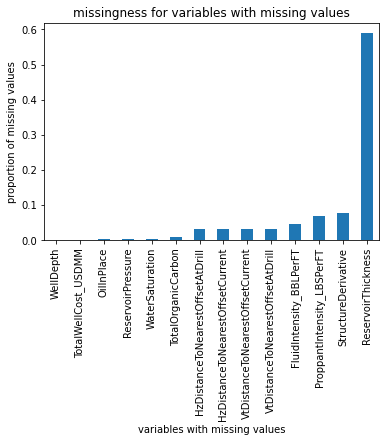

In [6]:
og_train.notnull().mean().sub(1).mul(-1).replace(0, np.nan).dropna().sort_values().plot.bar(
    title='missingness for variables with missing values',
    ylabel='proportion of missing values',
    xlabel='variables with missing values'
)

- Biggest observation found from the histograms below is that the distance measures have lots of value in the maxed values (2000 or 500). That's why we added max indicator to the dataset

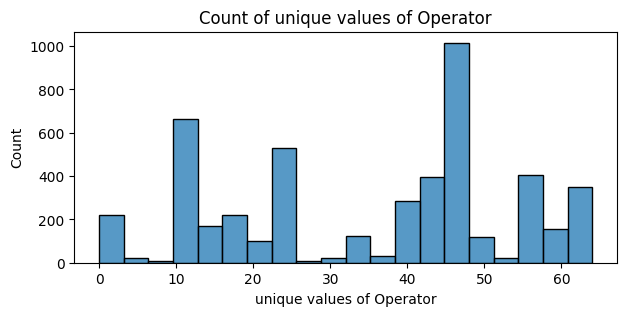

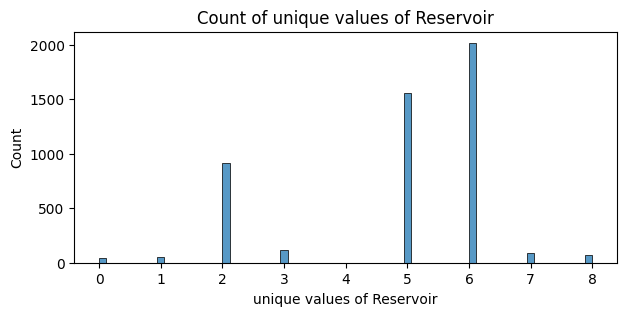

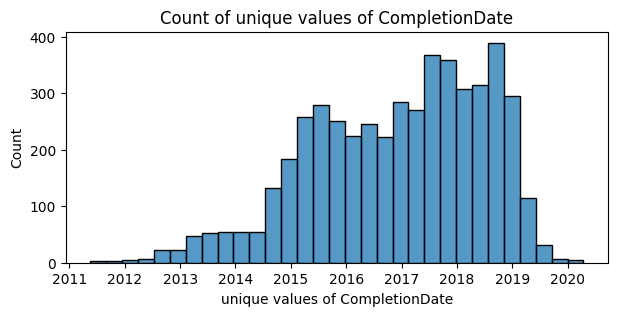

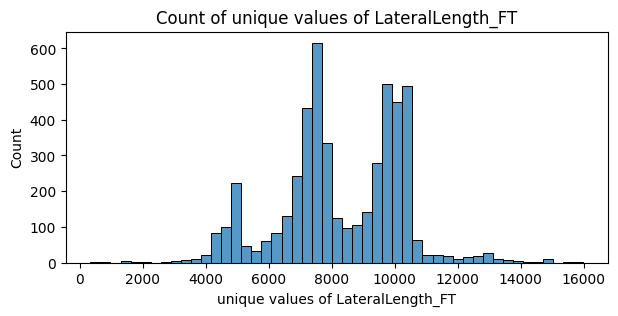

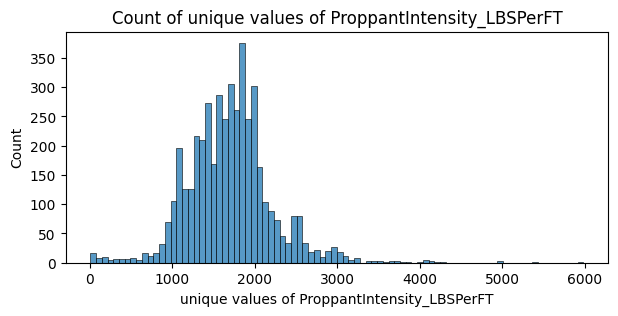

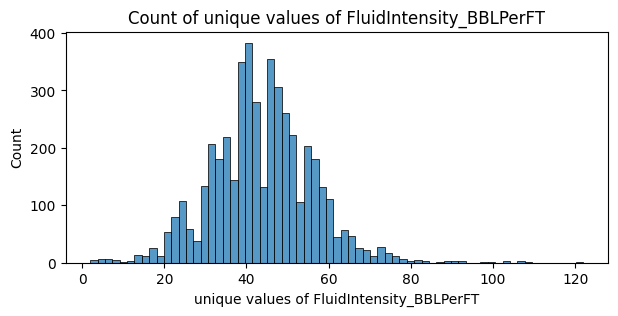

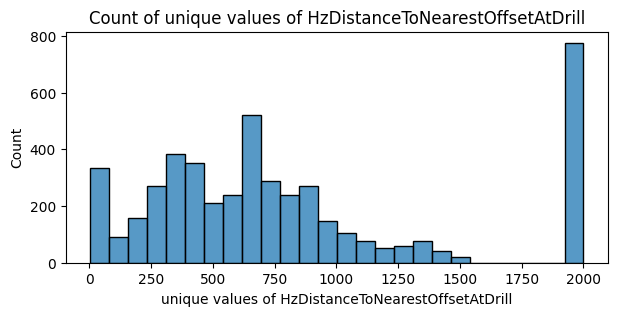

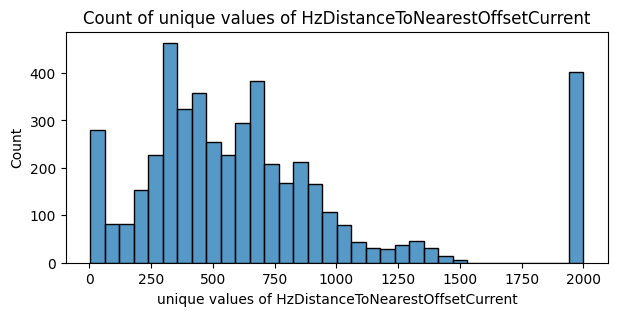

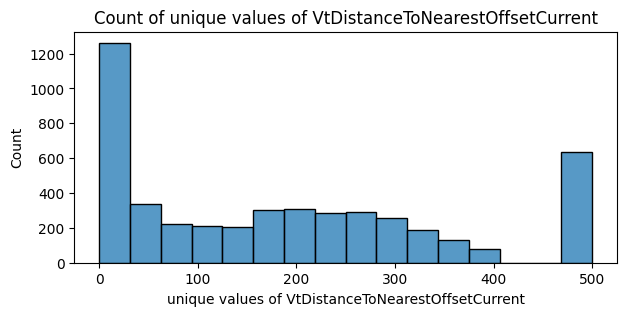

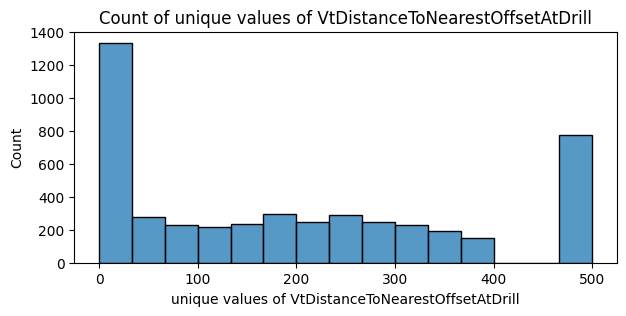

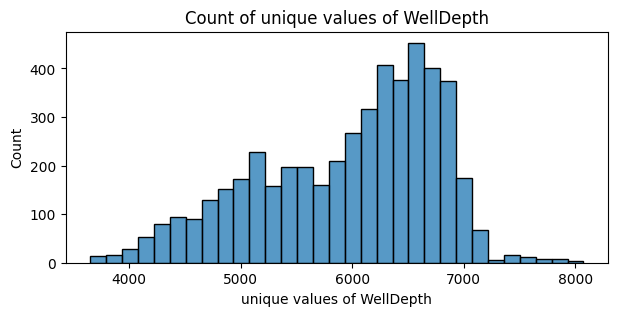

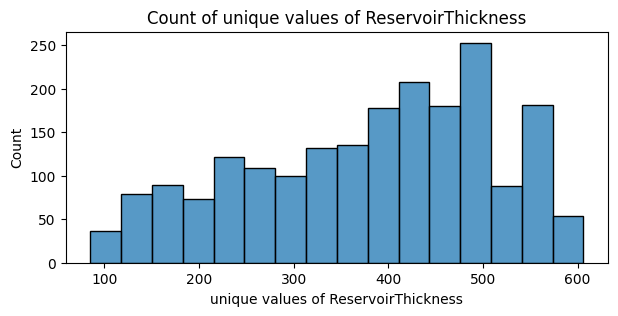

In [ ]:
for k, v in og_train.iloc[:, :12].items():
    ax = plt.subplots(figsize=(7, 3))[1]
    ax = sns.histplot(v.dropna(), ax=ax)
    ax.set_title(f"Count of unique values of {k}")
    ax.set_xlabel(f"unique values of {k}")

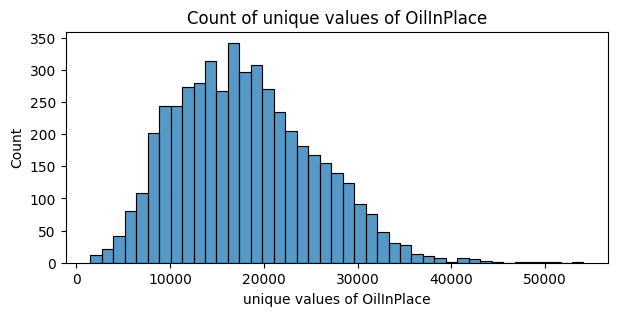

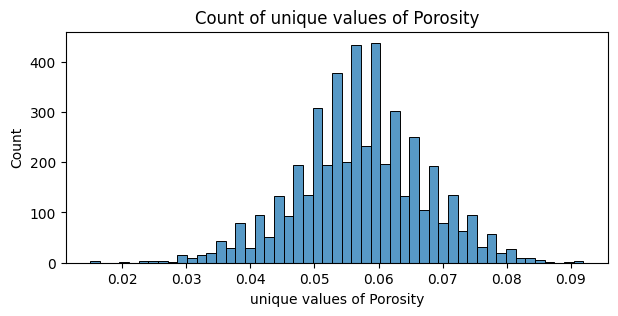

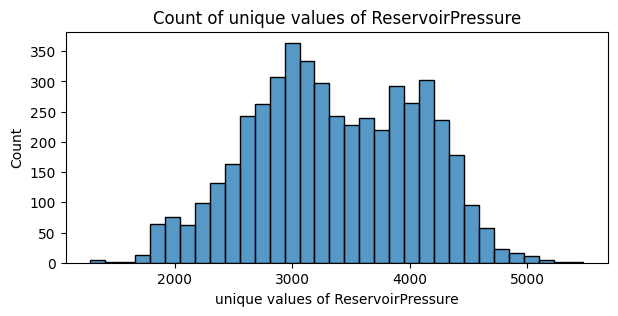

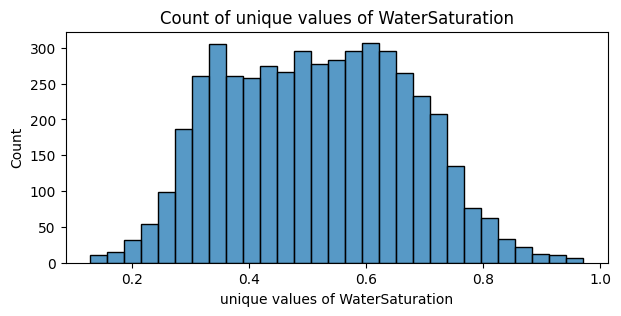

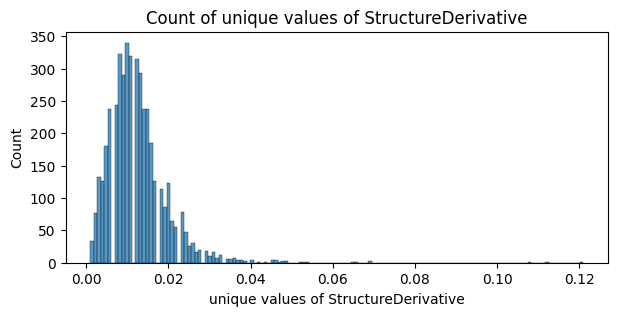

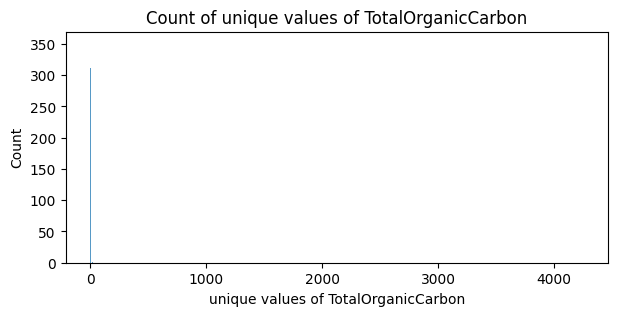

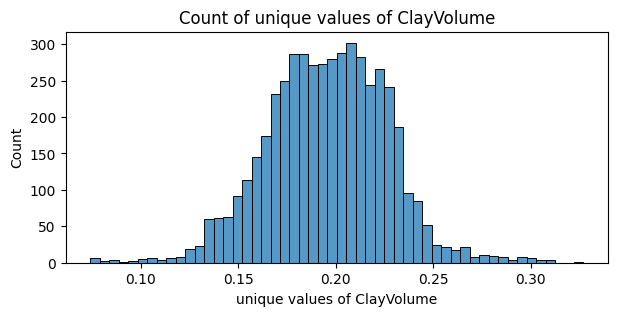

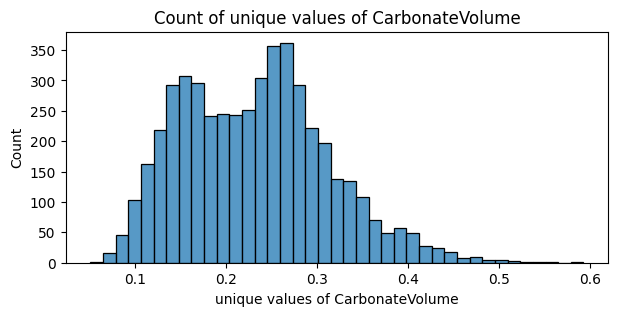

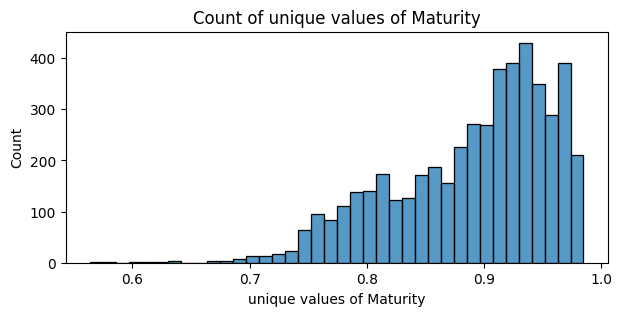

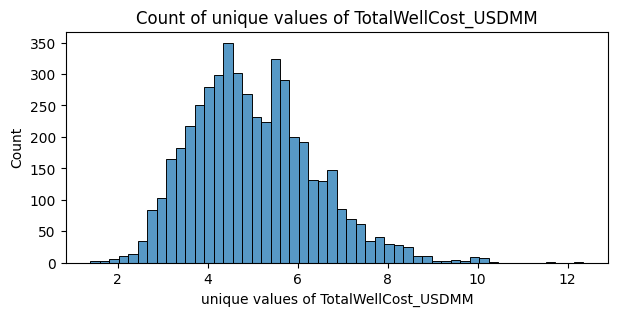

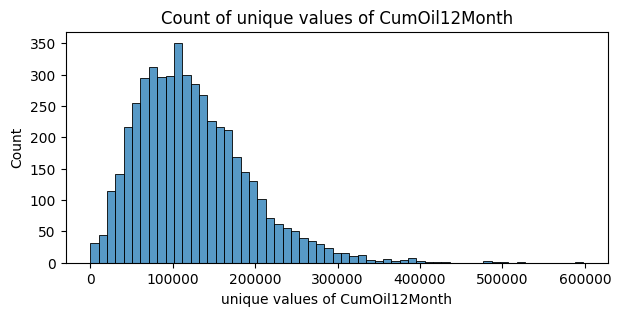

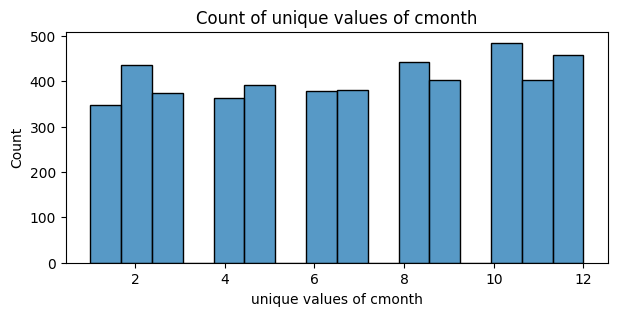

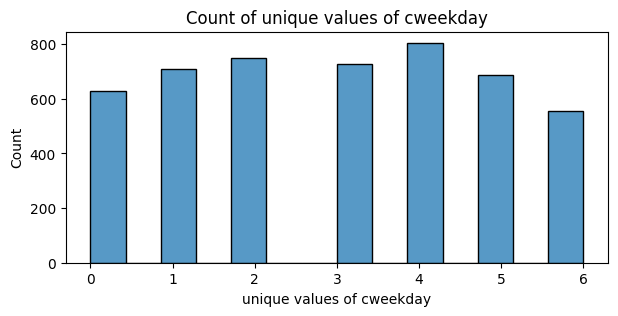

In [ ]:
for k, v in og_train.iloc[:, 12:].items():
    ax = plt.subplots(figsize=(7, 3))[1]
    ax = sns.histplot(v.dropna(), ax=ax)
    ax.set_title(f"Count of unique values of {k}")
    ax.set_xlabel(f"unique values of {k}")

Text(0.5, 1.0, "variables' simple correlation")

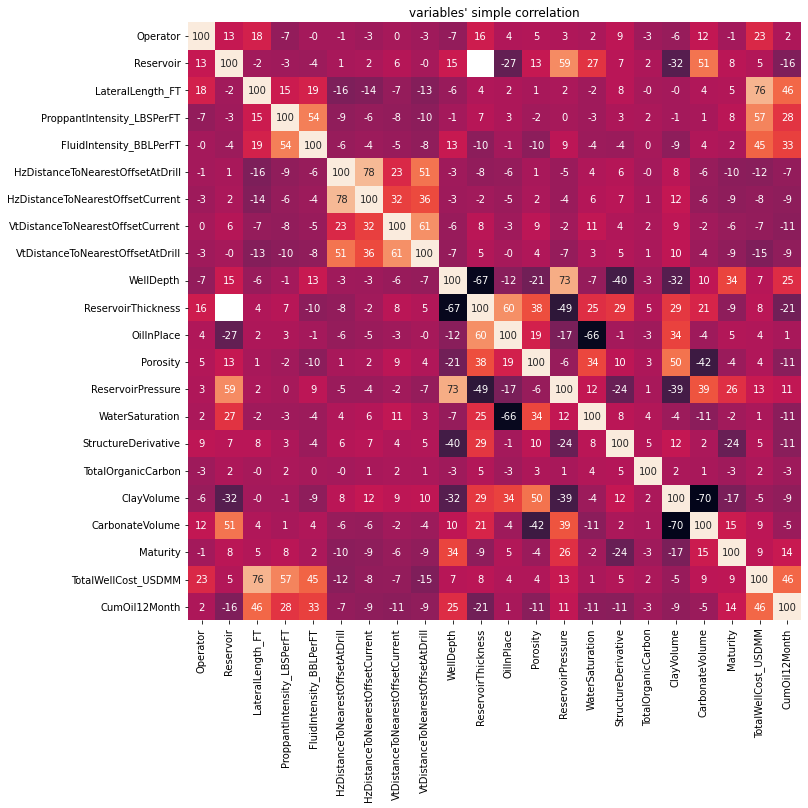

In [13]:

ax = plt.subplots(figsize=(11, 11))[1]

ax = sns.heatmap(
    og_raw.corr() * 100,
    annot=True,
    cbar=False,
    fmt='.0f',
    # mask=np.triu(),
    ax=ax
)
ax.set_title("variables' simple correlation")

In [ ]:
og_full.apply(lambda x: len(x.unique())).sort_values()

cweekday                               7
Reservoir                              8
cmonth                                12
StructureDerivative                   60
Operator                              64
Porosity                              71
FluidIntensity_BBLPerFT              100
ClayVolume                           224
Maturity                             304
CarbonateVolume                      417
WaterSaturation                      724
ReservoirThickness                  1726
ProppantIntensity_LBSPerFT          1813
CompletionDate                      1922
LateralLength_FT                    3093
VtDistanceToNearestOffsetAtDrill    4045
VtDistanceToNearestOffsetCurrent    4580
HzDistanceToNearestOffsetAtDrill    4882
HzDistanceToNearestOffsetCurrent    5351
TotalOrganicCarbon                  6012
OilInPlace                          6037
ReservoirPressure                   6041
CumOil12Month                       6064
WellDepth                           6065
TotalWellCost_US

Text(0.5, 1.0, 'Data points counts vs Completion Date')

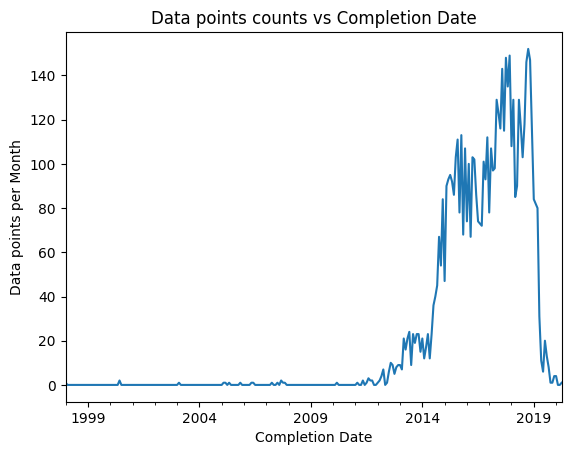

In [ ]:
ax = og_raw.set_index('CompletionDate').CumOil12Month.dropna().resample('M').count().plot()
ax.set_ylabel("Data points per Month")
ax.set_xlabel("Completion Date")
ax.set_title("Data points counts vs Completion Date")

<AxesSubplot: title={'center': 'Frequency of distance variables being capped per year'}, xlabel='year', ylabel='proportion of capped distance happening'>

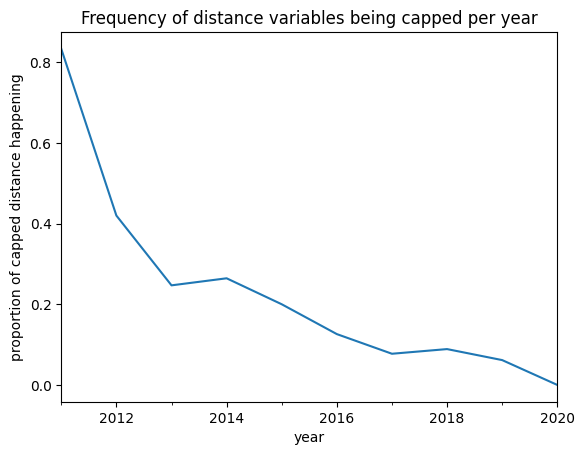

In [ ]:
og_train.set_index('CompletionDate').resample('A').apply(
    lambda x: (x[[
        'HzDistanceToNearestOffsetAtDrill', 'HzDistanceToNearestOffsetCurrent',
        'VtDistanceToNearestOffsetCurrent', 'VtDistanceToNearestOffsetAtDrill'
    ]].sub([2000, 2000, 500, 500]) == 0).mean().mean()
).plot(
    title='Frequency of distance variables being capped per year',
    xlabel='year', ylabel='proportion of capped distance happening'
    
)

# Imputation

- using the iterative imuputer from sklearn
- however, the sklearn's docstring says the fuctions are still under experiment. The interface can change any time
- we do trust the implementation being robust here

In [ ]:
mice_imputer = sklearn.impute.IterativeImputer(random_state=0)

X_train_test_orig = pd.concat([
    og_train, og_test
]).drop(
    columns=[
        'CompletionDate', 
        'ReservoirThickness', 'ReservoirThickness_Null',
        'TotalWellCost_USDMM', 'TotalWellCost_USDMM_Null', 
        'cweekday', 'CumOil12Month'
    ]
).pipe(pd.get_dummies, columns=['Operator', 'cmonth'])
    
X_train_orig = X_train_test_orig.iloc[:len(og_train)]
X_test_orig = X_train_test_orig.iloc[-len(og_test):]

y_train = og_train.CumOil12Month
y_test = og_test.CumOil12Month

X_train_mice = mice_imputer.fit_transform(X_train_orig)
X_test_mice = mice_imputer.transform(X_test_orig)

In [ ]:
og_train_mice = pd.read_csv('og_train_mice.csv', index_col=0)
og_test_mice = pd.read_csv('og_test_mice.csv', index_col=0)

In [ ]:
X_train_mice = og_train_mice.drop(columns=['Y'])
y_train = og_train_mice.Y

X_test_mice = og_test_mice.drop(columns=['Y'])
y_test = og_test_mice.Y


# Baseline and Ridge/Lasso

In [ ]:
scaler = StandardScaler().fit(np.concatenate([X_train_mice.values], axis=0))
X_train_scaled = scaler.transform(X_train_mice.values)
X_test_scaled = scaler.transform(X_test_mice.values)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_mice.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_mice.columns)

In [ ]:
#Baseline multi-linear model
linreg=LinearRegression(fit_intercept=True)
linreg.fit(X_train_scaled, y_train)

# Train R2
linreg_train_r2 = r2_score(y_train, linreg.predict(X_train_scaled))
#Test
linreg_test_r2 =r2_score(y_test, linreg.predict(X_test_scaled))



In [ ]:
#Regularization using RidgeCV
alphas = (0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000)
ridge_r2 = []
for i in alphas:
    fitted_ridge  = RidgeCV(alphas=[i], cv=10, scoring="r2").fit(X_train_scaled, y_train.ravel())
    ridge_r2.append(fitted_ridge.score(X_train_scaled, y_train))

fitted_ridge  = RidgeCV(alphas=[alphas[np.argmax(ridge_r2)]], cv=10, scoring="r2").fit(X_train_scaled, y_train.ravel())
ridge_train_r2 = fitted_ridge.score(X_train_scaled, y_train)
ridge_test_r2 = fitted_ridge.score(X_test_scaled, y_test)


#Regularization using LassoCV
lasso_r2 = []
for i in alphas:
    fitted_lasso  = LassoCV(alphas=[i], cv=10, max_iter=10000).fit(X_train_scaled, y_train.ravel())
    lasso_r2.append(fitted_lasso.score(X_train_scaled, y_train))
    
fitted_lasso  = LassoCV(alphas=[alphas[np.argmax(lasso_r2)]], cv=10, max_iter=10000).fit(X_train_scaled, y_train.ravel())
lasso_train_r2 = fitted_lasso.score(X_train_scaled, y_train)
lasso_test_r2 = fitted_lasso.score(X_test_scaled, y_test)


In [ ]:
print("the training r2 for baseline model is", linreg_train_r2)
print("the testing r2 for baseline model is", linreg_test_r2)
print("the best alpha for ridge is",  alphas[np.argmax(ridge_r2)])
print("the best training r2 for ridge is",  ridge_train_r2)
print("the best testing r2 for ridge is",  ridge_test_r2)
print("the best alpha for lasso is",  alphas[np.argmax(ridge_r2)])
print("the best training r2 for lasso is",  lasso_train_r2)
print("the best testing r2 for lasso is",  lasso_test_r2)

the training r2 for baseline model is 0.4972367454867286
the testing r2 for baseline model is 0.41150916925764713
the best alpha for ridge is 1e-05
the best training r2 for ridge is 0.49912467396073346
the best testing r2 for ridge is 0.41703703803875114
the best alpha for lasso is 1e-05
the best training r2 for lasso is 0.4991246401592079
the best testing r2 for lasso is 0.4170485325230854


In [ ]:
results_df = pd.DataFrame({
    'model': ['multi-linear', 'ridge', 'lasso'],
    'training score': [linreg_train_r2, ridge_train_r2, lasso_train_r2],
    'testing score': [linreg_test_r2, ridge_test_r2, lasso_test_r2]
})
results_df.to_csv('lin_res.csv')
results_df

,model,training score,testing score
0,multi-linear,0.497237,0.411509
1,ridge,0.499125,0.417037
2,lasso,0.499125,0.417049


In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# ax1.plot(np.log10(alphas), ridge_r2,label="training_r2")
# ax1.fill_between(np.log10(alphas), np.array(ridge_r2)+np.std(ridge_r2), np.array(ridge_r2)-np.std(ridge_r2), color = 'purple', alpha = 0.2, label='+/- 1 Standard deviations')
# ax1.axhline(ridge_test_r2, color="r", linestyle = '--', label="optimal_test_r2")
# ax1.set_xlabel('log10(alpha)', fontsize=15)
# ax1.set_ylabel('Cross Validated $R^2$', fontsize=15)
# ax1.set_title('RidgeCV $R^2$(mean from 10 folds) vs alpha', fontsize=20)
# ax1.set_ylim(0.3, 0.55)
# ax1.legend(fontsize=15)

# ax2.plot(np.log10(alphas), lasso_r2, label="training_r2")
# ax2.axhline(lasso_test_r2, color="r", linestyle = '--', label="optimal_test_r2")
# ax2.fill_between(np.log10(alphas), np.array(lasso_r2)+np.std(lasso_r2), np.array(lasso_r2)-np.std(lasso_r2), color = 'purple', alpha = 0.2, label='+/- 1 Standard deviations')
# ax2.set_xlabel('log10(alpha)', fontsize=15)
# ax2.set_ylabel('Cross Validated $R^2$', fontsize=15)
# ax2.set_title('LassoCV $R^2$(mean from 10 folds)vs alpha', fontsize=20)
# ax2.set_ylim(0.3, 0.55)
# ax2.set_xlim(-6, 0)
# ax2.legend(fontsize=15)

In [ ]:
def plot_imp_bar(perm, feature_names, feature_drop=[], top=15, figsize=(9, 3), title=None):
    imp = pd.DataFrame({
        'importance': perm.feature_importances_,
        'imp_std': perm.feature_importances_std_

    }, index=X_test_mice.columns).drop(feature_drop)
    
    imp['imp_abs'] = imp.importance.abs()
    
    imp_top = imp.nlargest(top, 'imp_abs')
    
    ax = imp_top.importance.plot.bar(
        title=title, yerr=imp_top.imp_std,
        figsize=figsize,
        ylabel='weight',
        xlabel='predictors'
    )
    
    return ax

<AxesSubplot: title={'center': 'Feature Importance of Ridge'}, xlabel='predictors', ylabel='weight'>

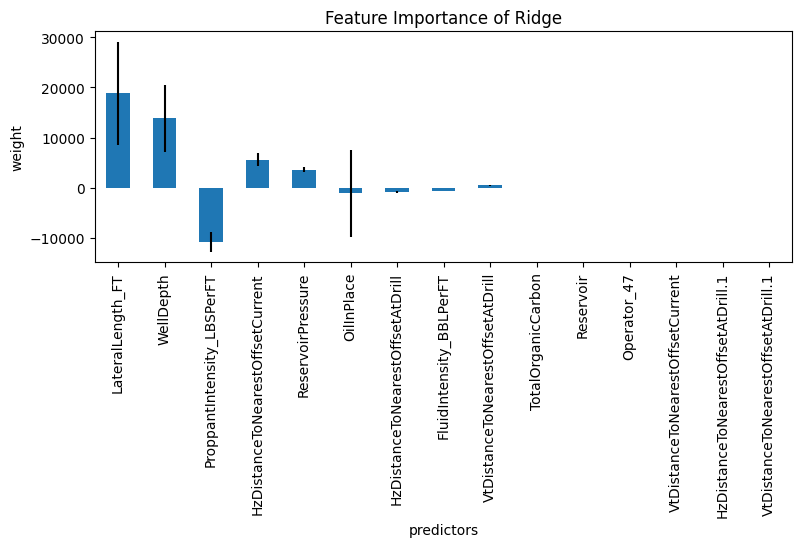

In [ ]:
perm_ridge = PermutationImportance(fitted_ridge, random_state=42, n_iter=10).fit(X_test_mice, y_test)
plot_imp_bar(perm_ridge, X_test_mice.columns, title='Feature Importance of Ridge')

<AxesSubplot: title={'center': 'Feature Importance of Lasso'}, xlabel='predictors', ylabel='weight'>

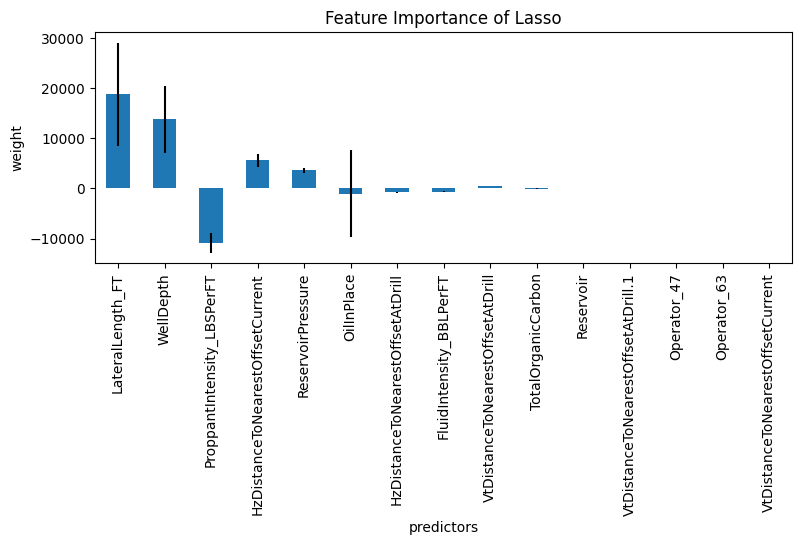

In [ ]:
perm_lasso = PermutationImportance(fitted_lasso, random_state=42, n_iter=10).fit(X_test_mice, y_test)
plot_imp_bar(perm_lasso, X_test_mice.columns, title='Feature Importance of Lasso')

In [ ]:
#Manually read importance from LassoCV based on coef values
# importance = np.abs(fitted_lasso.coef_)
# df = pd.DataFrame(importance, index = X_train_scaled.columns, columns = ["importance"])
# lasso_importance = df[df.importance>0.00001]
# lasso_importance = lasso_importance.sort_values('importance', ascending=False)
# lasso_importance

In [ ]:
#joblib save model
# dump(rf, "rf.joblib")
# dump(fitted_lasso, "fitted_lasso.joblib")
# dump(fitted_ridge, "fitted_ridge.joblib")
# rf = load("rf.joblib")
# fitted_lasso = load("fitted_lasso.joblib")
# fitted_ridge = load("fitted_ridge.joblib")
# pd.Series({"LassoCV": fitted_lasso,"RandomForest":rf, "RidgeCV": fitted_ridge})

In [ ]:
#Feature importance by mRMR
# F = pd.Series(f_regression(X_train_mice, y_train)[0], index = X_train_mice.columns)
# corr = pd.DataFrame(.00001, index = X_train_mice.columns, columns = X_train_mice.columns)

# # initialize list of selected features and list of excluded features
# selected = []
# not_selected = X_train_mice.columns.to_list()

# # repeat 20 times
# for i in range(20):
  
#     # compute (absolute) correlations between the last selected feature and all the (currently) excluded features
#     if i > 0:
#         last_selected = selected[-1]
#         corr.loc[not_selected, last_selected] = X_train_mice[not_selected].corrwith(X_train_mice[last_selected]).abs().clip(.00001)
        
#     # compute FCQ score for all the (currently) excluded features (this is Formula 2)
#     score = F.loc[not_selected] / corr.loc[not_selected, selected].mean(axis = 1).fillna(.00001)
    
#     # find best feature, add it to selected and remove it from not_selected
#     best = score.index[score.argmax()]
#     selected.append(best)
#     not_selected.remove(best)

In [ ]:
#feature importance by LassoCV
# eli5.show_weights(fitted_lasso, feature_names = X_train_scaled.columns.tolist())

In [ ]:
# feature_importance = pd.DataFrame(list(zip(X_test_mice.columns.tolist(), perm.feature_importances_))[:20], columns =["Permutation", "importance"])
# feature_importance=feature_importance.sort_values('importance', ascending=False)
# feature_importance["LassoCV"] = lasso_importance.index[:20]
# feature_importance["mRMR"] = selected
# feature_importance=feature_importance.drop("importance", axis=1)
# feature_importance = feature_importance.reset_index(drop=True)

In [ ]:
# styles = [dict(selector="caption",
#                        props=[("text-align", "center"),
#                               ("font-size", "150%"),
#                               ("color", 'black')])]

# feature_importance.style.set_caption('Top 20 features descending from Most important by different algorithm').set_table_styles(styles)



## Tree based models

**Loading in the preprocessed train and test data**

In [2]:
og_train_mice = pd.read_csv('og_train_mice.csv', index_col=0)
og_test_mice = pd.read_csv('og_test_mice.csv', index_col=0)

X_train_mice = og_train_mice.drop(columns=['Y'])
y_train = og_train_mice.Y

X_test_mice = og_test_mice.drop(columns=['Y'])
y_test = og_test_mice.Y

### Single decision tree (best depth identified with cross validation)

**Identifying optimal tree depth with cross validation.**

In [6]:
# your code here
tree_depth = 20
train_scores = []
cvmeans = []
cvstds = []

for depth in range(1, tree_depth+1):
    dt = DecisionTreeRegressor(max_depth=depth).fit(X_train_mice, y_train)
    train_score = dt.score(X_train_mice, y_train)
    train_scores.append(train_score)

    cv_results = cross_val_score(dt, X_train_mice, y_train, cv=5)
    cvmeans.append(cv_results.mean())
    cvstds.append(cv_results.std())

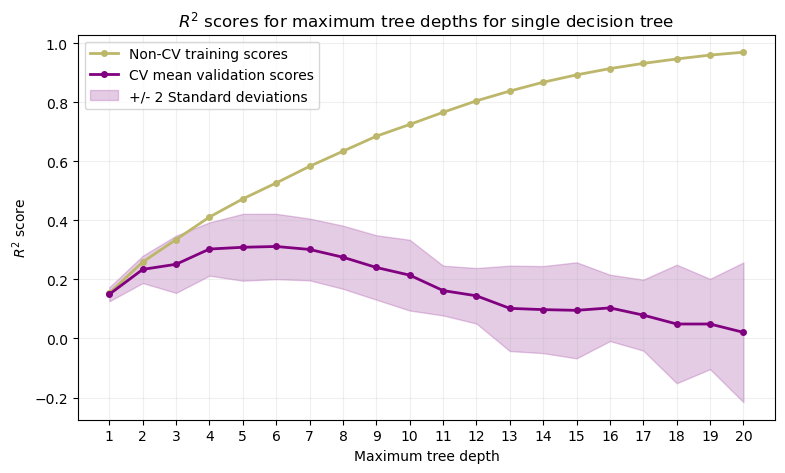

In [7]:
plt.figure(figsize=(9,5))
plt.grid(True, alpha=0.2)
plt.plot(list(range(1, tree_depth+1)), train_scores, color='darkkhaki', lw=2, label="Non-CV training scores", marker='o', markersize=4)
plt.plot(list(range(1, tree_depth+1)), cvmeans, color='purple', lw=2, label="CV mean validation scores", marker='o', markersize=4)
plt.fill_between(list(range(1, tree_depth+1)), np.array(cvmeans)+2*np.array(cvstds), np.array(cvmeans)-2*np.array(cvstds), color = 'purple', alpha = 0.2, label='+/- 2 Standard deviations')
plt.xlabel('Maximum tree depth')
plt.ylabel(r'$R^2$ score')
plt.xticks(list(range(1, tree_depth+1)))
plt.legend()
plt.title(r'$R^2$ scores for maximum tree depths for single decision tree');

In [8]:
best_cv_depth = np.argmax(cvmeans)+1
print(f'The highest mean CV score is {max(cvmeans):.3f}.')
print(f'The best tree depth identified through CV was {best_cv_depth}.')

The highest mean CV score is 0.312.
The best tree depth identified through CV was 6.


**Fitting single tree model to entire train data with best identified tree depth.**

- No random state set for single DecisionTree as it's not the main model to study. As a result the stats for single Decision Tree will be a bit different each time we fit. 
- The purpose of including single DecisionTree is to have some rough baseline for tree based models
- We set random_state for the 3 other tree-based models. However, XGBoost still produces different instances with random_state is unchanged.

In [9]:
dt_1 = DecisionTreeRegressor(max_depth=best_cv_depth).fit(X_train_mice, y_train)
best_cv_tree_train_score = dt_1.score(X_train_mice, y_train)
best_cv_tree_test_score = dt_1.score(X_test_mice, y_test)

In [10]:
# print model results summary
print(
    "The tree of max-depth {} trained on the "
    "full training set, achieves the following accuracy scores:"
    "\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}".format(
        best_cv_depth,
        best_cv_tree_train_score,
        best_cv_tree_test_score,
    )
)

The tree of max-depth 6 trained on the full training set, achieves the following accuracy scores:

	train	0.5267
	TEST	0.3620


In [17]:
#Create and add first entry to results_df
results_df = create_results_df(dt_1, X_train_mice, y_train, X_test_mice, y_test)
#show results_df 
results_df


,model,training score,testing score
0,DecisionTreeRegressor,0.526705,0.361964


### Random Forest

**Identifying optimal tree depth with CV.**

In [18]:
n_trees_rf = 1000
tree_depth_rf = 60
train_scores_rf = []
cvmeans_rf = []
cvstds_rf = []

for depth in range(1, tree_depth_rf+1):
    rf = RandomForestRegressor(max_depth=depth,
                           n_estimators=n_trees_rf,
                           max_features=int(X_train_mice.shape[1]/3),
                           random_state=109,
                           n_jobs=-1)
    rf.fit(X_train_mice, y_train)
    train_score_rf = rf.score(X_train_mice, y_train)
    train_scores_rf.append(train_score_rf)

    cv_results_rf = cross_val_score(rf, X_train_mice, y_train, cv=5)
    cvmeans_rf.append(cv_results_rf.mean())
    cvstds_rf.append(cv_results_rf.std())

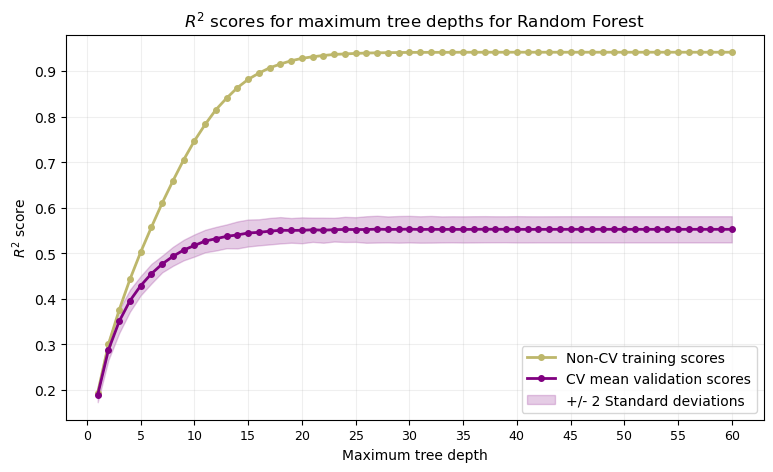

In [27]:
plt.figure(figsize=(9,5))
plt.grid(True, alpha=0.2)
plt.plot(list(range(1, tree_depth_rf+1)), train_scores_rf, color='darkkhaki', lw=2, label="Non-CV training scores", marker='o', markersize=4)
plt.plot(list(range(1, tree_depth_rf+1)), cvmeans_rf, color='purple', lw=2, label="CV mean validation scores", marker='o', markersize=4)
plt.fill_between(list(range(1, tree_depth_rf+1)), np.array(cvmeans_rf)+2*np.array(cvstds_rf), np.array(cvmeans_rf)-2*np.array(cvstds_rf), color = 'purple', alpha = 0.2, label='+/- 2 Standard deviations')
plt.xlabel('Maximum tree depth')
plt.ylabel(r'$R^2$ score')
#plt.ylim(0,1)
plt.xticks(np.arange(0, tree_depth_rf+1, 5), size=9)
plt.legend()
plt.title(r'$R^2$ scores for maximum tree depths for Random Forest');

In [20]:
best_cv_depth_rf = np.argmax(cvmeans_rf)+1
print(f'The highest mean CV accuracy score is {max(cvmeans_rf):.3f}.')
print(f'The best tree depth identified through CV is {best_cv_depth_rf}.')

The highest mean CV accuracy score is 0.553.
The best tree depth identified through CV is 30.


**Fitting Random Forest model on entire train data with best identified tree depth.**

In [21]:

rf_best = RandomForestRegressor(max_depth=best_cv_depth_rf,
                           n_estimators=n_trees_rf,
                           max_features=int(X_train_mice.shape[1]/3),
                           random_state=109, n_jobs=-1).fit(X_train_mice, y_train)
best_cv_rf_train_score = rf_best.score(X_train_mice, y_train)
best_cv_rf_test_score = rf_best.score(X_test_mice, y_test)

In [22]:
# print results summary
print(
    "The random forest of depth-{} and {} trees achieves the "
    "following accuracy scores:\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(
        best_cv_depth_rf,
        n_trees_rf,
        best_cv_rf_train_score,
        best_cv_rf_test_score,
    )
)

The random forest of depth-30 and 1000 trees achieves the following accuracy scores:

	train	0.9406
	TEST	0.4956


In [24]:

#Add entry to results_df
results_df = add_to_results_df(results_df, rf_best, X_train_mice, y_train, X_test_mice, y_test)
#show results_df 
results_df

,model,training score,testing score
0,DecisionTreeRegressor,0.526705,0.361964
0,RandomForestRegressor,0.940570,0.495573


## Extratrees

**Identifying optimal tree depth with CV.**

In [25]:
tree_depth_ex = 60
train_scores_ex = []
cvmeans_ex = []
cvstds_ex = []

for depth in range(1, tree_depth_ex+1):
    ex = ExtraTreesRegressor(max_depth=depth,
                           n_estimators=n_trees_rf,
                           max_features=int(X_train_mice.shape[1]/3),
                           random_state=109, n_jobs=-1).fit(X_train_mice, y_train)
    train_score_ex = ex.score(X_train_mice, y_train)
    train_scores_ex.append(train_score_ex)

    cv_results_ex = cross_val_score(ex, X_train_mice, y_train, cv=5)
    cvmeans_ex.append(cv_results_ex.mean())
    cvstds_ex.append(cv_results_ex.std())

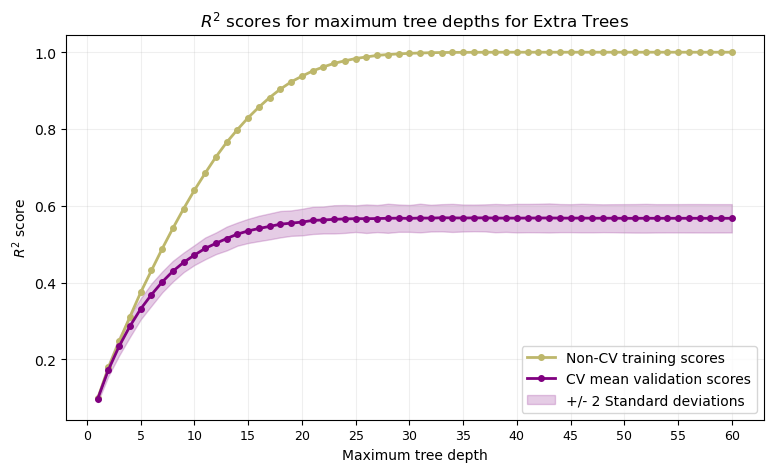

In [28]:
plt.figure(figsize=(9,5))
plt.grid(True, alpha=0.2)
plt.plot(list(range(1, tree_depth_ex+1)), train_scores_ex, color='darkkhaki', lw=2, label="Non-CV training scores", marker='o', markersize=4)
plt.plot(list(range(1, tree_depth_ex+1)), cvmeans_ex, color='purple', lw=2, label="CV mean validation scores", marker='o', markersize=4)
plt.fill_between(list(range(1, tree_depth_ex+1)), np.array(cvmeans_ex)+2*np.array(cvstds_ex), np.array(cvmeans_ex)-2*np.array(cvstds_ex), color = 'purple', alpha = 0.2, label='+/- 2 Standard deviations')
plt.xlabel('Maximum tree depth')
plt.ylabel(r'$R^2$ score')
#plt.ylim(0,1)
plt.xticks(np.arange(0, tree_depth_rf+1, 5), size=9)
plt.legend()
plt.title(r'$R^2$ scores for maximum tree depths for Extra Trees');

In [29]:
best_cv_depth_ex = np.argmax(cvmeans_ex)+1
print(f'The highest mean CV accuracy score is {max(cvmeans_ex):.3f}.')
print(f'The best tree depth identified through CV was {best_cv_depth_ex}.')

The highest mean CV accuracy score is 0.569.
The best tree depth identified through CV was 33.


**Fitting Extra Trees model on entire train data with best identified tree depth.**

In [30]:
n_trees_ex = 10000

ex_best = ExtraTreesRegressor(max_depth=best_cv_depth_ex,
                           n_estimators=n_trees_ex,
                           max_features=36,
                           random_state=109, n_jobs=-1).fit(X_train_mice, y_train)
best_cv_ex_train_score = ex_best.score(X_train_mice, y_train)
best_cv_ex_test_score = ex_best.score(X_test_mice, y_test)

In [31]:
# print results summary
print(
    "The random forest of depth-{} and {} trees achieves the "
    "following accuracy scores:\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(
        best_cv_depth_ex,
        n_trees_ex,
        best_cv_ex_train_score,
        best_cv_ex_test_score,
    )
)

The random forest of depth-33 and 10000 trees achieves the following accuracy scores:

	train	0.9992
	TEST	0.5038


**Finetuning hyperparameters using grid search CV**

In [32]:
param_grid_2 = {
    'n_estimators': [100],
    'max_depth': [2,8,16,32,50],
    'min_samples_split': [2,4,6],
    'min_samples_leaf': [1,2],
    'max_features': [1.0,'sqrt','log2'],    
    'bootstrap': [True, False],
    'warm_start': [True, False],
}

In [ ]:
gcv = GridSearchCV(ExtraTreesRegressor(), param_grid_2, cv=5, n_jobs=-1, verbose=3, refit=True).fit(X_train_mice, y_train)


In [302]:
print('The best identified hyperparameters through GridSearch are:')
print(gcv.best_params_) 

The best identified hyperparameters through GridSearch are:
{'bootstrap': False, 'max_depth': 32, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'warm_start': True}


**Fitting final Extra Trees model with tuned hyperparameters**

In [33]:
ex_best_tuned = ExtraTreesRegressor(max_depth=32,
                           n_estimators=10000,
                           max_features=1.0,
                           min_samples_leaf=2,
                           min_samples_split = 2,
                           warm_start=True,
                           bootstrap=False,
                           random_state=109, n_jobs=-1).fit(X_train_mice, y_train)
best_cv_ex_tuned_train_score = ex_best_tuned.score(X_train_mice, y_train)
best_cv_ex_tuned_test_score = ex_best_tuned.score(X_test_mice, y_test)

In [34]:
# print results summary
print(
    "The random forest of depth-{} and {} trees achieves the "
    "following accuracy scores:\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(
        best_cv_depth_ex,
        n_trees_ex,
        best_cv_ex_tuned_train_score,
        best_cv_ex_tuned_test_score,
    )
)

The random forest of depth-33 and 10000 trees achieves the following accuracy scores:

	train	0.9630
	TEST	0.5042


In [35]:
#Add entry to results_df
results_df = add_to_results_df(results_df, ex_best_tuned, X_train_mice, y_train, X_test_mice, y_test)
#show results_df 
results_df

,model,training score,testing score
0,DecisionTreeRegressor,0.526705,0.361964
0,RandomForestRegressor,0.940570,0.495573
0,ExtraTreesRegressor,0.962971,0.504249


In [ ]:
results_df.to_csv('res_trees.csv')

**Assessing feature importance**

Helper function for plotting feature importance

In [36]:
def plot_imp_bar(perm, feature_names, feature_drop=[], top=15, figsize=(9, 3), title=None):
    imp = pd.DataFrame({
        'importance': perm.feature_importances_,
        'imp_std': perm.feature_importances_std_

    }, index=X_test_mice.columns).drop(feature_drop)
    
    imp['imp_abs'] = imp.importance.abs()
    
    imp_top = imp.nlargest(top, 'imp_abs')
    
    ax = imp_top.importance.plot.bar(
        title=title, yerr=imp_top.imp_std,
        figsize=figsize,
        ylabel='weight',
        xlabel='predictors'
    )
    
    return ax

Feature importance for random forest model

<AxesSubplot:title={'center':'Feature importances of Random Forest'}, xlabel='predictors', ylabel='weight'>

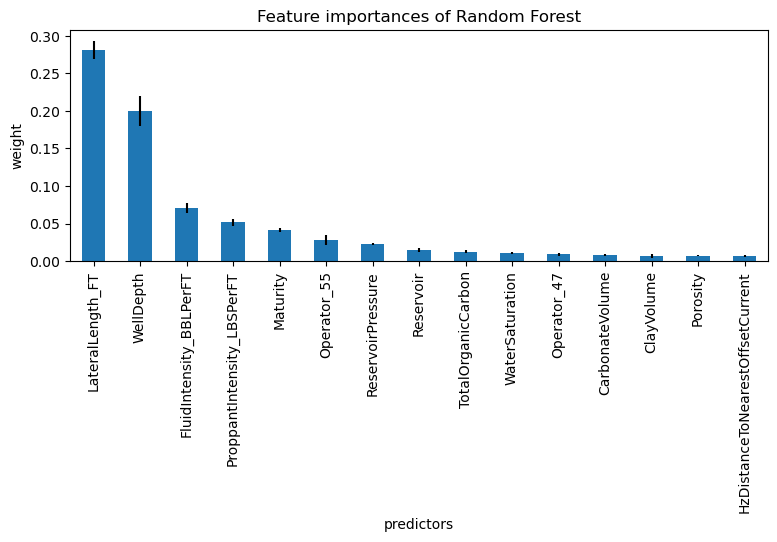

In [39]:
perm_rf = PermutationImportance(rf_best, random_state=109).fit(X_test_mice, y_test)


plot_imp_bar(perm_rf, X_test_mice.columns, title= 'Feature importances of Random Forest')

<AxesSubplot:title={'center':'Feature importances of Extra Trees'}, xlabel='predictors', ylabel='weight'>

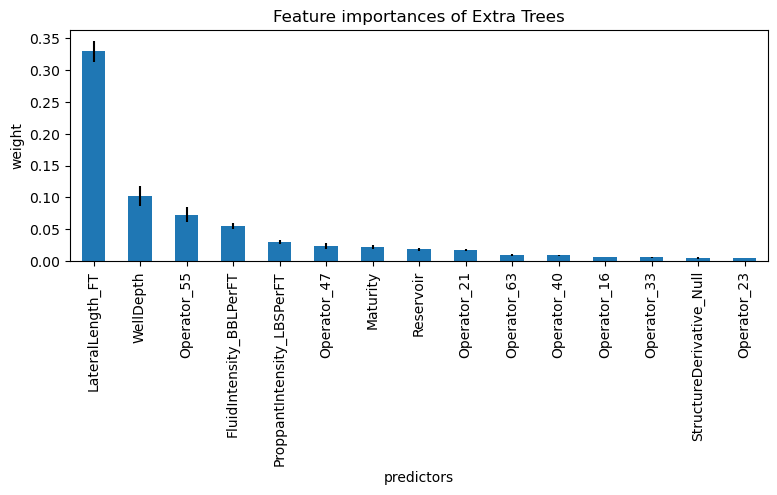

In [40]:
perm_ex = PermutationImportance(ex_best_tuned, random_state=109).fit(X_test_mice, y_test)

plot_imp_bar(perm_ex, X_test_mice.columns, title='Feature importances of Extra Trees')

##XGBoost##

## **XGBoost**

In [20]:
og_train_mice = pd.read_csv('og_train_mice.csv')
og_test_mice = pd.read_csv('og_test_mice.csv')

X_train_mice = og_train_mice.drop(columns=['Y'])
y_train = og_train_mice.Y

X_test_mice = og_test_mice.drop(columns=['Y'])
y_test = og_test_mice.Y


In [4]:
# grid search with more verbosity and treating max_depth as the primary hyperparameter 
def get_xgbr_repo(max_depths, param_grid, X_train, y_train, X_test, y_test,
          early_stopping_rounds=150, eval_metric='rmse', n_estimators=5000,
          random_state=88, cv=3, verbose=3, scoring='f1', n_jobs=1, tree_method='auto'):
    sys.stdout.flush()
    start = timer()
    print(f"Start time: {pd.Timestamp.now(tz='US/Eastern')}")
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_train, y_train, test_size=0.2, random_state=random_state,
        stratify=X_train.Reservoir,
    )
    CV_xgbr_repo = pd.Series({
        _: mselect.GridSearchCV(
            scoring=scoring,
            estimator=xgb.XGBRegressor(
                random_state=random_state, max_depth=_,
                early_stopping_rounds=early_stopping_rounds,
                eval_metric=eval_metric,
                objective='reg:squarederror',
                tree_method=tree_method,
                n_estimators=n_estimators,
                verbosity=1
            ), 
            param_grid=param_grid, 
            cv=cv, 
            n_jobs=n_jobs,
            verbose=verbose,
        ) for _ in max_depths
    })

    for k, v in CV_xgbr_repo.items():
        sys.stdout.flush()
        print(f'============= depths: {k}=============')
        v.fit(
            X_tr, y_tr, 
            eval_set=((X_va, y_va),),
            verbose=False
        )
        sys.stdout.flush()
        print(f'============= depths: {k} done =============')
        print(v.best_params_, round(v.best_score_, 3), v.best_estimator_.best_iteration)
        print('r2: {:.4f}, mse: {:.4f}'.format(
            skmet.r2_score(y_test, v.predict(X_test),), 
            skmet.mean_squared_error(y_test, v.predict(X_test),),
        ))
        end = timer()
        print()
        print(f'Minutes so far: {(end - start) / 60:.2f}')
        sys.stdout.flush()


    print()
    print(CV_xgbr_repo.apply(lambda x: x.best_score_).round(4).to_string())
    
    end = timer()
    print()
    print(f'Total minutes: {(end - start) / 60:.2f}')
    sys.stdout.flush()
    return CV_xgbr_repo



In [ ]:
### tuning

###### %%time

# fine tuning
param_grid = {
    'learning_rate': [0.05, 0.01, 0.004, 0.002, 0.001][::-1],
    'subsample': [0.25, 0.5, 0.75, 0.95],
    # 'gamma': [0, 1, 5],
    'colsample_bynode': [0.05, 0.12, 0.25, 0.45, 0.7],
}


# rough tuning
# param_grid = {
#     'learning_rate': [0.05],
#     'subsample': [0.75],
#     # 'gamma': [0, 1, 5],
#     'colsample_bynode': [0.2, 0.7],
# }


# deeper trees
xgbr_repo_deep = get_xgbr_repo(
    list(range(11, 17))[::-1],
  param_grid,
  X_train_mice, y_train, X_test_mice, y_test,
  scoring='r2', n_estimators=15000, n_jobs=-1, verbose=10,
  tree_method='auto'
)
# joblib.dump(xgbr_repo_deep, 'xgbr_deep.pkl')



xgbr_repo_shallow = get_xgbr_repo(
    # [2, 4, 6, 9, 13, 17, 22, 28] # rough tuning
    list(range(5, 11)), # fine tuning
  param_grid,
  X_train_mice, y_train, X_test_mice, y_test,
  scoring='r2', n_estimators=15000, n_jobs=-1, verbose=10,
  tree_method='auto'
)

# joblib.dump(xgbr_repo_shallow, 'xgbr_shallow.pkl')

# skipping the output for readability

In [ ]:
# loading
xgbr_repo_deep = joblib.load('xgbr_deep.pkl')
xgbr_repo_shallow = joblib.load('xgbr_shallow.pkl')

In [17]:
xgbr_repo_shallow.loc[7].best_params_

{'colsample_bynode': 0.12, 'learning_rate': 0.004, 'subsample': 0.75}

In [18]:
xgbr_repo_best = pd.concat([
        xgbr_repo_shallow,
        xgbr_repo_deep
    ]).sort_index().apply(lambda x: x.best_estimator_)

In [27]:
xgbr_repo_best.apply(lambda x: pd.Series(x.predict(X_test_mice))).loc[5:11].mean().pipe(
    lambda x: skmet.r2_score(y_test, x)
)

0.5101313475368071

In [73]:
xgbr_repo_best

5     XGBRegressor(base_score=0.5, booster='gbtree',...
6     XGBRegressor(base_score=0.5, booster='gbtree',...
7     XGBRegressor(base_score=0.5, booster='gbtree',...
8     XGBRegressor(base_score=0.5, booster='gbtree',...
9     XGBRegressor(base_score=0.5, booster='gbtree',...
10    XGBRegressor(base_score=0.5, booster='gbtree',...
11    XGBRegressor(base_score=0.5, booster='gbtree',...
12    XGBRegressor(base_score=0.5, booster='gbtree',...
13    XGBRegressor(base_score=0.5, booster='gbtree',...
14    XGBRegressor(base_score=0.5, booster='gbtree',...
15    XGBRegressor(base_score=0.5, booster='gbtree',...
16    XGBRegressor(base_score=0.5, booster='gbtree',...
dtype: object

In [75]:
joblib.dump(xgbr_repo_best, 'xgbr_best.pkl', compress=3)

['xgbr_best.pkl']

In [ ]:
xgbr_repo_best = joblib.load('xgbr_best.pkl')

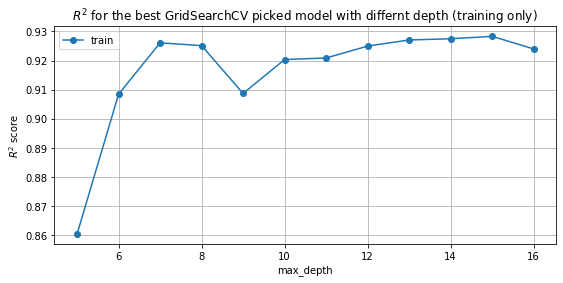

In [31]:
xgb_trscore = xgbr_repo_best.apply(
    lambda x: pd.Series({
        'train': x.score(X_train_mice, y_train),
        # 'CV (mean)': x.best_score_,
        # 'test': x.best_estimator_.score(X_test_mice, y_test)
    })
)


ax = xgb_trscore.plot(
    figsize=(9, 4), grid=True, marker='o',
    ylabel='$R^2$ score', xlabel='max_depth',
    title='$R^2$ for the best GridSearchCV picked model with differnt depth (training only)'
)


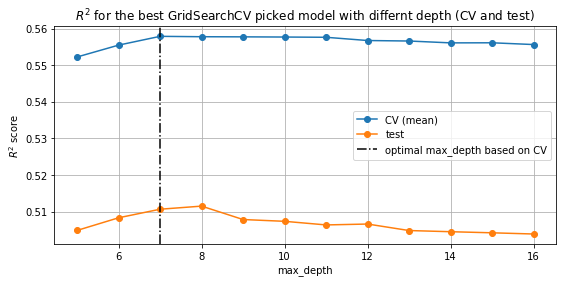

In [33]:
xgb_cvtest = pd.concat([
        xgbr_repo_shallow,
        xgbr_repo_deep
    ]).sort_index().apply(
    lambda x: pd.Series({
        # 'train': x.best_estimator_.score(X_train_mice, y_train),
        'CV (mean)': x.best_score_,
        'test': x.best_estimator_.score(X_test_mice, y_test)
    })
)


ax = xgb_cvtest.plot(
    figsize=(9, 4), grid=True, marker='o',
    ylabel='$R^2$ score', xlabel='max_depth',
    title='$R^2$ for the best GridSearchCV picked model with differnt depth (CV and test)'
)

ax.axvline(xgb_cvtest.iloc[:, 0].idxmax(), ls='-.', c='k', label='optimal max_depth based on CV')
ax.legend()

<AxesSubplot:title={'center':'Learning curve of the best XGB regressor (end stage)'}, xlabel='n_iteration', ylabel='Validation score (RMSE)'>

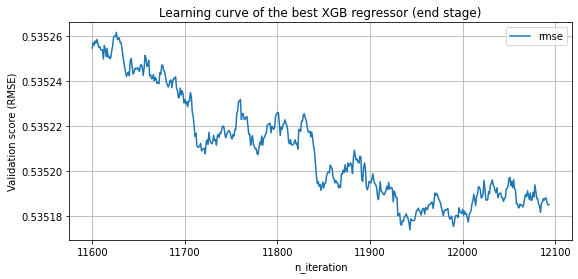

In [21]:
pd.DataFrame(xgbr_repo_best.loc[7].evals_result()['validation_0']).loc[11600:].plot(
    title='Learning curve of the best XGB regressor (end stage)',
    ylabel='Validation score (RMSE)',
    xlabel='n_iteration',
    figsize=(9, 4), grid=True
)

<AxesSubplot:title={'center':'Feature Importance of XGB'}, xlabel='predictors', ylabel='weight'>

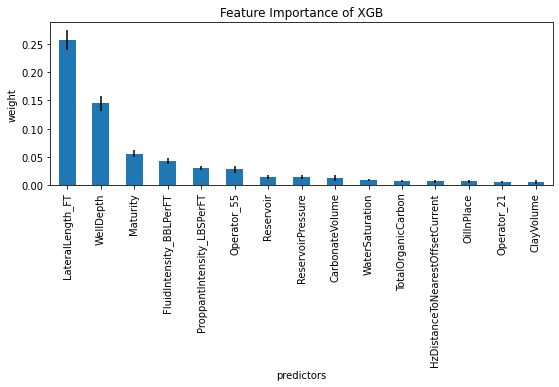

In [7]:
def plot_imp_bar(perm, feature_names, feature_drop=[], top=15, figsize=(9, 3), title=None):
    imp = pd.DataFrame({
        'importance': perm.feature_importances_,
        'imp_std': perm.feature_importances_std_

    }, index=X_test_mice.columns).drop(feature_drop)
    
    imp['imp_abs'] = imp.importance.abs()
    
    imp_top = imp.nlargest(top, 'imp_abs')
    
    ax = imp_top.importance.plot.bar(
        title=title, yerr=imp_top.imp_std,
        figsize=figsize,
        ylabel='weight',
        xlabel='predictors'
    )
    
    return ax


perm_xgb = PermutationImportance(xgbr_repo_best.loc[7], random_state=42, n_iter=10).fit(X_test_mice, y_test)
plot_imp_bar(perm_xgb, X_test_mice.columns, title='Feature Importance of XGB')


- playing around refitting to check the effectiveness of random_state below
- skipping the output for readeability
- but the refits generate different model instances even all the hyperparameters are unchanged

In [ ]:
# 
_X_tr, _X_va, _y_tr, _y_va = train_test_split(
        X_train_mice, y_train, test_size=0.2, random_state=88,
        stratify=X_train_mice.Reservoir,
    )


xgb_refit = {}
# xgb_refit_test = {}


for k, v in pd.concat([
        xgbr_repo_shallow,
        xgbr_repo_deep
    ]).sort_index().items():

    print(k)
    _reg = xgb.XGBRegressor(
        early_stopping_rounds=150, eval_metric='rmse', n_estimators=20000, max_depth=k,
        random_state=88, tree_method='gpu_hist', **v.best_params_
    ).fit(_X_tr, _y_tr, eval_set=((_X_va, _y_va), ), verbose=False)
    
    print(_reg.score(_X_va, _y_va))
    print(_reg.score(X_test_mice, y_test))
    print(_reg.best_iteration)
    xgb_refit[k] = _reg
xgb_refit = pd.Series(xgb_refit)


In [19]:
joblib.dump(xgb_refit, 'xgbr_refit.pkl')

['xgbr_refit.pkl']

### Results table

In [ ]:
res_all = pd.concat([
    res_lin,
    results_df,
    pd.Series({
        'model': 'XGBRgressor',
        'training score': xgb_trscore.loc[7, 'train'],
        'testing score': xgb_cvtest.loc[7, 'test'],
    }).to_frame().T
]).set_index('model').astype('float')
res_all.round(4).assign(**{'tree depth': ['', '', '', 6, 30, 32, 7]})
res_all.to_csv('results_all.csv')


In [ ]:
res_all = pd.read_csv('results_all.csv', index_col=0, dtype={'tree depth': str}).fillna('')
res_all

,training score,testing score,tree depth
model,,,
multi-linear,0.4972,0.4115,
ridge,0.4991,0.4170,
lasso,0.4991,0.4170,
DecisionTreeRegressor,0.5267,0.3796,6
RandomForestRegressor,0.9406,0.4956,30
ExtraTreesRegressor,0.9630,0.5042,32
XGBRgressor,0.9261,0.5106,7


In [11]:
res_all.iloc[2:]

,training score,testing score,tree depth
model,,,
lasso,0.4991,0.4170,
DecisionTreeRegressor,0.5267,0.3796,6
RandomForestRegressor,0.9406,0.4956,30
ExtraTreesRegressor,0.9630,0.5042,32
XGBRgressor,0.9261,0.5106,7


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7d41d969-abec-4fc5-a90d-434108e5892a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>